<a href="https://colab.research.google.com/github/daemonkil/OurBus-Data-Scientist-Assignment/blob/main/OurBus_Data_Scientist_Assignment_3_Himanshu_Bansal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pystan==2.19.1.1
!pip install prophet

     |████████████████████████████████| 71kB 5.4MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 184kB 12.9MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-cp37-none-any.whl size=6639815 sha256=34ab573fd622eceadf239f4995699fc68f85cf9cd92fc1de2998ecf07762c63a
  Stored in directory: /root/.cache/pip/wheels/92/1d/02/bc0a91bd3a84e060722075d2b0b68e875e37ec7dc49451d513
Successfully built prophet
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [ ]:
import pandas as pd
from prophet import Prophet
import plotly.graph_objects as go

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Data Scientist Interview Assignment.xlsx to Data Scientist Interview Assignment (1).xlsx


In [ ]:
import io
df = pd.read_excel(io.BytesIO(uploaded['Data Scientist Interview Assignment.xlsx']))

In [ ]:
data = df

In [ ]:
data.isna().sum()

order_no               0
discount_amount        0
adults                 0
booking_fee            0
paid_from_wallet       0
order_time             0
source                 0
isRelease              0
trip_type              0
leg_name               0
commission             0
departure_time         0
bf_discount            0
trip_id                0
isCancel               0
net_revenue            0
base_id                0
travel_date            0
ff_discount            0
facility_fee           0
amount_in_usd          0
voucher_consumption    0
paid_from_card         0
pick_stop              0
dtype: int64

In [ ]:
data = data.drop(["pick_stop","leg_name","trip_type","isRelease","booking_fee","commission","bf_discount","isCancel",
                  "ff_discount","voucher_consumption"], axis=1)

In [ ]:
# Using Time Series
data["total_revenue"] = data["adults"]*data["amount_in_usd"]

In [ ]:
data["date"] = [d.date() for d in df['order_time']]

In [ ]:
prophet_per_day = data.groupby(["date"], as_index=False)["total_revenue"].sum()
prophet_per_day.columns = ["ds","y"]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=prophet_per_day["ds"], y=prophet_per_day["y"],
                    mode='lines+markers',
                    name='lineplot'))
fig.show()


In [ ]:
prophet_per_day

,ds,y
0,2019-09-25,1200.25
1,2019-09-26,1000.50
2,2019-09-27,603.50
3,2019-09-28,20.50
4,2019-09-29,194.50


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.


,ds,floor,cap
10,2019-10-05,20,1500
11,2019-10-06,20,1500
12,2019-10-07,20,1500
13,2019-10-08,20,1500
14,2019-10-09,20,1500


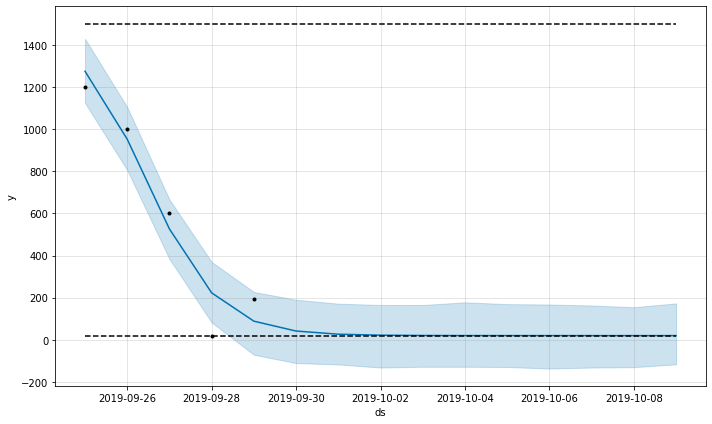

In [ ]:
# Forecasting by prophet
prophet_per_day['floor'] = 20
prophet_per_day['cap'] = 1500
m = Prophet(growth='logistic')
m.fit(prophet_per_day)

future = m.make_future_dataframe(periods=10)
future['floor'] = 20
future['cap'] = 1500
fcst = m.predict(future)
fig = m.plot(fcst)
future.tail()

Summary, due to less data available, prophet gives unsatisfied forecastings.

**Neural Prophet**

In [ ]:
pip install neuralprophet

  Using cached https://files.pythonhosted.org/packages/20/52/1e00f0713b9e0e040f38834e94b6f3c3dd55b7f291e77664f27eb670abb6/neuralprophet-0.2.7-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5d/5e/35140615fc1f925023f489e71086a9ecc188053d263d3594237281284d82/torch-1.6.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/ea/51/1a869067989a0fdaf18e49f0ee3aebfcb63470525245aac7dc390cfc676a/torch_lr_finder-0.2.1-py3-none-any.whl
ERROR: torchvision 0.9.0+cu101 has requirement torch==1.8.0, but you'll have torch 1.6.0 which is incompatible.
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.6.0 which is incompatible.


In [ ]:
from neuralprophet import NeuralProphet

In [ ]:
neural_prophet_data = prophet_per_day[["ds","y"]]

In [ ]:
model = NeuralProphet(
    growth="linear",  # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None, # list of dates that may include change points (None -> automatic )
    n_changepoints=5,
    changepoints_range=0.8,
    trend_reg=0,
    trend_reg_threshold=False,
    yearly_seasonality="auto",
    weekly_seasonality="auto",
    daily_seasonality="auto",
    seasonality_mode="additive",
    seasonality_reg=0,
    n_forecasts=1,
    n_lags=0,
    num_hidden_layers=0,
    d_hidden=None,     # Dimension of hidden layers of AR-Net
    ar_sparsity=None,  # Sparcity in the AR coefficients
    learning_rate=None,
    epochs=40,
    loss_func="Huber",
    normalize="auto",  # Type of normalization ('minmax', 'standardize', 'soft', 'off')
    impute_missing=True,
    log_level=None, # Determines the logging level of the logger object
)

In [ ]:
metrics = model.fit(neural_prophet_data, validate_each_epoch=True, freq="D") 
future = model.make_future_dataframe(neural_prophet_data, periods=350, n_historic_predictions=len(neural_prophet_data)) 
forecast = model.predict(future)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:nprophet.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:nprophet.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to ov

  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E-01
INFO:nprophet:learning rate range test found optimal lr: 1.00E-01
Epoch[40/40]: 100%|██████████| 40/40 [00:00<00:00, 74.81it/s, SmoothL1Loss=0.000201, MAE=27.7, RegLoss=0, MAE_val=686, SmoothL1Loss_val=0.108]


In [ ]:
forecast[:10]

,ds,y,yhat1,residual1,trend
0,2019-09-25,1200.25,1222.463745,22.213745,1222.463745
1,2019-09-26,1000.50,956.064087,-44.435913,956.064087
2,2019-09-27,603.50,586.397156,-17.102844,586.397156
3,2019-09-28,20.50,47.656982,27.156982,47.656982
4,2019-09-29,194.50,-491.083191,-685.583191,-491.083191
5,2019-09-30,NaN,-1029.823364,NaN,-1029.823364
6,2019-10-01,NaN,-1568.563477,NaN,-1568.563477
7,2019-10-02,NaN,-2107.303711,NaN,-2107.303711
8,2019-10-03,NaN,-2646.043945,NaN,-2646.043945
9,2019-10-04,NaN,-3184.784180,NaN,-3184.784180


Neural Prophet is not initialized because of less number of time series data

In [ ]:
data

,order_no,discount_amount,adults,paid_from_wallet,order_time,source,departure_time,trip_id,net_revenue,base_id,travel_date,facility_fee,amount_in_usd,paid_from_card,total_revenue,date,new_time,time_hour
0,774016,11.25,1,0,2019-09-25 03:47:29,WEB,06:25:00,16009,0.0,294729,2019-09-25,0,11.25,0.0,11.25,2019-09-25,03,3
1,774017,11.25,1,0,2019-09-25 03:48:52,WEB,17:30:00,310958,0.0,294729,2019-09-25,0,11.25,0.0,11.25,2019-09-25,03,3
2,774027,10.25,1,0,2019-09-25 05:24:09,IOS,06:25:00,16009,0.0,1338,2019-09-25,0,10.25,0.0,10.25,2019-09-25,05,5
3,774027,10.25,1,0,2019-09-25 05:24:09,IOS,17:30:00,310958,0.0,1338,2019-09-25,0,10.25,0.0,10.25,2019-09-25,05,5
4,774029,11.25,1,0,2019-09-25 05:38:44,WEB,06:25:00,16009,0.0,35,2019-09-25,0,11.25,0.0,11.25,2019-09-25,05,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,782656,11.25,1,0,2019-09-29 21:57:11,IOS,06:55:00,117711,0.0,430,2019-09-30,0,11.25,0.0,11.25,2019-09-29,21,21
266,782699,11.25,1,0,2019-09-29 22:13:58,WEB,06:25:00,16009,0.0,294729,2019-09-30,0,11.25,0.0,11.25,2019-09-29,22,22
267,782704,11.25,1,0,2019-09-29 22:15:15,WEB,17:30:00,310958,0.0,294729,2019-09-30,0,11.25,0.0,11.25,2019-09-29,22,22
268,782706,11.25,1,0,2019-09-29 22:16:58,IOS,06:55:00,117711,0.0,260,2019-09-30,0,11.25,0.0,11.25,2019-09-29,22,22


In [ ]:
data["datetime_new"]= [datetime.strptime(str(i),'%Y-%m-%d %H:%M:%S').strftime("%Y-%m-%d %H:00:00") for i in data["order_time"]]

In [ ]:
data

,order_no,discount_amount,adults,paid_from_wallet,order_time,source,departure_time,trip_id,net_revenue,base_id,travel_date,facility_fee,amount_in_usd,paid_from_card,total_revenue,date,new_time,time_hour,datetime_new
0,774016,11.25,1,0,2019-09-25 03:47:29,WEB,06:25:00,16009,0.0,294729,2019-09-25,0,11.25,0.0,11.25,2019-09-25,03,3,2019-09-25 03:00:00
1,774017,11.25,1,0,2019-09-25 03:48:52,WEB,17:30:00,310958,0.0,294729,2019-09-25,0,11.25,0.0,11.25,2019-09-25,03,3,2019-09-25 03:00:00
2,774027,10.25,1,0,2019-09-25 05:24:09,IOS,06:25:00,16009,0.0,1338,2019-09-25,0,10.25,0.0,10.25,2019-09-25,05,5,2019-09-25 05:00:00
3,774027,10.25,1,0,2019-09-25 05:24:09,IOS,17:30:00,310958,0.0,1338,2019-09-25,0,10.25,0.0,10.25,2019-09-25,05,5,2019-09-25 05:00:00
4,774029,11.25,1,0,2019-09-25 05:38:44,WEB,06:25:00,16009,0.0,35,2019-09-25,0,11.25,0.0,11.25,2019-09-25,05,5,2019-09-25 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,782656,11.25,1,0,2019-09-29 21:57:11,IOS,06:55:00,117711,0.0,430,2019-09-30,0,11.25,0.0,11.25,2019-09-29,21,21,2019-09-29 21:00:00
266,782699,11.25,1,0,2019-09-29 22:13:58,WEB,06:25:00,16009,0.0,294729,2019-09-30,0,11.25,0.0,11.25,2019-09-29,22,22,2019-09-29 22:00:00
267,782704,11.25,1,0,2019-09-29 22:15:15,WEB,17:30:00,310958,0.0,294729,2019-09-30,0,11.25,0.0,11.25,2019-09-29,22,22,2019-09-29 22:00:00
268,782706,11.25,1,0,2019-09-29 22:16:58,IOS,06:55:00,117711,0.0,260,2019-09-30,0,11.25,0.0,11.25,2019-09-29,22,22,2019-09-29 22:00:00


In [ ]:
d = data[["datetime_new","total_revenue"]]
data_per_hour = d.groupby(["datetime_new"], as_index=False)["total_revenue"].sum()

In [ ]:
data_per_hour.index = pd.DatetimeIndex(data_per_hour['datetime_new']).floor('H')

In [ ]:
data_per_hour.head()

,datetime_new,total_revenue
datetime_new,,
2019-09-25 03:00:00,2019-09-25 03:00:00,22.50
2019-09-25 05:00:00,2019-09-25 05:00:00,52.25
2019-09-25 06:00:00,2019-09-25 06:00:00,518.75
2019-09-25 07:00:00,2019-09-25 07:00:00,88.00
2019-09-25 10:00:00,2019-09-25 10:00:00,11.25
2019-09-25 11:00:00,2019-09-25 11:00:00,11.25
2019-09-25 14:00:00,2019-09-25 14:00:00,22.50
2019-09-25 16:00:00,2019-09-25 16:00:00,56.25
2019-09-25 17:00:00,2019-09-25 17:00:00,225.00


In [ ]:
all_days = pd.date_range(data_per_hour.index.min(), data_per_hour.index.max(), freq='H')
data_per_hour = data_per_hour.reindex(all_days)

In [ ]:
data_per_hour = data_per_hour.fillna(0)

In [ ]:
data_per_hour["datetime_new"] = data_per_hour.index

In [ ]:
data_per_hour

,datetime_new,total_revenue
2019-09-25 03:00:00,2019-09-25 03:00:00,22.50
2019-09-25 04:00:00,2019-09-25 04:00:00,0.00
2019-09-25 05:00:00,2019-09-25 05:00:00,52.25
2019-09-25 06:00:00,2019-09-25 06:00:00,518.75
2019-09-25 07:00:00,2019-09-25 07:00:00,88.00
...,...,...
2019-09-29 19:00:00,2019-09-29 19:00:00,20.50
2019-09-29 20:00:00,2019-09-29 20:00:00,11.25
2019-09-29 21:00:00,2019-09-29 21:00:00,86.00
2019-09-29 22:00:00,2019-09-29 22:00:00,33.75


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_per_hour["datetime_new"], y=data_per_hour["total_revenue"],
                    mode='lines+markers',
                    name='revenue Per hour'))
fig.show()


In [ ]:
data_per_hour.columns = ["ds", "y"]

Prophet model for revenue per hour to increase the data

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


,ds,floor,cap
113,2019-09-29 20:00:00,20,700
114,2019-09-29 21:00:00,20,700
115,2019-09-29 22:00:00,20,700
116,2019-09-29 23:00:00,20,700
117,2019-09-30 23:00:00,20,700


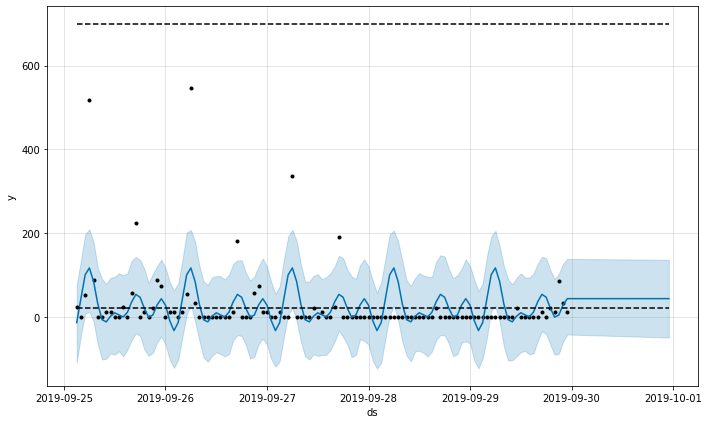

In [ ]:
# Forecasting by prophet
data_per_hour['floor'] = 20
data_per_hour['cap'] = 700
m = Prophet(growth='logistic')
m.fit(data_per_hour)

future = m.make_future_dataframe(periods=1)
future['floor'] = 20
future['cap'] = 700
fcst = m.predict(future)
fig = m.plot(fcst)
future.tail()

Neural Prophet output for per hour revenue

In [ ]:
model = NeuralProphet(
    growth="linear",  # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None, # list of dates that may include change points (None -> automatic )
    n_changepoints=5,
    changepoints_range=0.8,
    trend_reg=0,
    trend_reg_threshold=False,
    yearly_seasonality="auto",
    weekly_seasonality="auto",
    daily_seasonality="auto",
    seasonality_mode="additive",
    seasonality_reg=0,
    n_forecasts=1,
    n_lags=0,
    num_hidden_layers=50,
    d_hidden=2,     # Dimension of hidden layers of AR-Net
    ar_sparsity=None,  # Sparcity in the AR coefficients
    learning_rate=None,
    epochs=100,
    loss_func="Huber",
    normalize="auto",  # Type of normalization ('minmax', 'standardize', 'soft', 'off')
    impute_missing=True,
    log_level=None, # Determines the logging level of the logger object
)

In [ ]:
data_per_hour_neural = data_per_hour[["ds","y"]]

In [ ]:
metrics = model.fit(data_per_hour_neural, validate_each_epoch=True, freq="H") 
future = model.make_future_dataframe(data_per_hour_neural, periods=5, n_historic_predictions=len(data_per_hour_neural)) 
forecast = model.predict(future)

INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:nprophet.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:nprophet.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 2
INFO:nprophet.config:Auto-set batch_size to 2


  0%|          | 0/100 [00:00<?, ?it/s]

ERROR: nprophet - _lr_range_test: Failed to compute the gradients, there might not be enough points.
ERROR:nprophet:Failed to compute the gradients, there might not be enough points.
ERROR: nprophet - _lr_range_test: lr range test failed. defaulting to lr: 0.1
ERROR:nprophet:lr range test failed. defaulting to lr: 0.1
Epoch[100/100]: 100%|██████████| 100/100 [00:06<00:00, 15.42it/s, SmoothL1Loss=0.171, MAE=33.1, RegLoss=0, MAE_val=35.7, SmoothL1Loss_val=0.0978]


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=forecast["ds"], y=forecast["y"],
                    mode='lines+markers',
                    name='revenue Per hour by neural prophet'))
fig.show()


Neural Prophet is not providing better results because of vanishing gradient problem.